<a href="https://practicalai.me"><img src="https://raw.githubusercontent.com/practicalAI/images/master/images/rounded_logo.png" width="100" align="left" hspace="20px" vspace="20px"></a>

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/convolution.gif" width="200" align="right">

<div align="left">
<h1>Convolutional Neural Networks (CNN)</h1>

In this lesson we will explore the basics of Convolutional Neural Networks (CNNs) applied to text for natural language processing (NLP) tasks.

<table align="center">
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/rounded_logo.png" width="25"><a target="_blank" href="https://practicalai.me"> View on practicalAI</a>
  </td>
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/colab_logo.png" width="25"><a target="_blank" href="https://colab.research.google.com/github/practicalAI/practicalAI/blob/master/notebooks/10_Convolutional_Neural_Networks.ipynb"> Run in Google Colab</a>
  </td>
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/github_logo.png" width="22"><a target="_blank" href="https://github.com/practicalAI/practicalAI/blob/master/notebooks/basic_ml/10_Convolutional_Neural_Networks.ipynb"> View code on GitHub</a>
  </td>
</table>

# Overview

* **Objective:**  Detect spatial substructure from input data.
* **Advantages:** 
  * Small number of weights (shared)
  * Parallelizable
  * Detects spatial substrcutures (feature extractors)
  * [Interpretability](https://arxiv.org/abs/1312.6034) via filters
  * Used for in images/text/time-series etc.
* **Disadvantages:**
  * Many hyperparameters (kernel size, strides, etc.)
* **Miscellaneous:** 
  * Lot's of deep CNN architectures constantly updated for SOTA performance


# Set up

In [1]:
# Use TensorFlow 2.x
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import os
import numpy as np
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [0]:
# Arguments
SEED = 1234
SHUFFLE = True
DATA_FILE = 'news.csv'
INPUT_FEATURE = 'title'
OUTPUT_FEATURE = 'category'
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True
CHAR_LEVEL = True
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
NUM_EPOCHS = 10
BATCH_SIZE = 64
NUM_FILTERS = 50
FILTER_SIZE = 3 # tri-grams
HIDDEN_DIM = 100
DROPOUT_P = 0.1
LEARNING_RATE = 1e-3
EARLY_STOPPING_CRITERIA = 3

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data

We will download the [AG News dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which consists of 120000 text samples from 4 unique classes ('Business', 'Sci/Tech', 'Sports', 'World')

In [0]:
import pandas as pd
import re
import urllib

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/practicalAI/practicalAI/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [7]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[INPUT_FEATURE].values
y = df[OUTPUT_FEATURE].values
df.head(5)

,title,category
0,Wall St. Bears Claw Back Into the Black (Reuters),Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


# Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

### Components

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

### Operations

In [10]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"X_train[0]: {X_train[0]}")
print (f"y_train[0]: {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (86700,), y_train: (86700,)
X_val: (15300,), y_val: (15300,)
X_test: (18000,), y_test: (18000,)
X_train[0]: PGA overhauls system for Ryder Cup points
y_train[0]: Sports
Classes: {'Business': 30000, 'Sci/Tech': 30000, 'Sports': 30000, 'World': 30000}


# Tokenizer

We're going to process our input text at the character level and then one-hot encode each character. Each character has a token id and the one hot representation for each character is an array of zeros except for the <token_id> index which is a 1. So in the example below, the letter e is the token index 2 and its one hot encoded form is an array of zeros except for a 1 at index 2 ( `[0. 0. 1. 0. ... 0.]` ).

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/onehot.png" width="900">

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

### Components

In [0]:
def untokenize(indices, tokenizer):
    """Untokenize a list of indices into string."""
    return " ".join([tokenizer.index_word[index] for index in indices])

In [0]:
def untokenize_one_hot(seq, tokenizer):
    """Untokenize a one-hot encoded matrix."""
    indices = [np.argmax(one_hot) for one_hot in seq]
    return untokenize(indices=indices, tokenizer=tokenizer)

### Operations

In [0]:
# Input vectorizer
X_tokenizer = Tokenizer(filters=FILTERS,
                        lower=LOWER,
                        char_level=CHAR_LEVEL,
                        oov_token='<UNK>')

In [15]:
# Fit only on train data
X_tokenizer.fit_on_texts(X_train)
vocab_size = len(X_tokenizer.word_index) + 1
print (f"# tokens: {vocab_size}")

# tokens: 58


In [16]:
# Convert text to sequence of tokens
original_text = X_train[0]
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = untokenize(X_train[0], X_tokenizer)
print (f"{original_text} \n\t→ {preprocessed_text} \n\t→ {X_train[0]}")

PGA overhauls system for Ryder Cup points 
	→ p g a   o v e r h a u l s   s y s t e m   f o r   r y d e r   c u p   p o i n t s 
	→ [15, 18, 5, 2, 7, 24, 3, 9, 16, 5, 14, 11, 4, 2, 4, 22, 4, 6, 3, 17, 2, 19, 7, 9, 2, 9, 22, 13, 3, 9, 2, 12, 14, 15, 2, 15, 7, 8, 10, 6, 4]


In [17]:
# One hot
X_train = np.array([to_categorical(seq, num_classes=vocab_size) for seq in X_train])
X_val = np.array([to_categorical(seq, num_classes=vocab_size) for seq in X_val])
X_test = np.array([to_categorical(seq, num_classes=vocab_size) for seq in X_test])
print (f"X_train[0]:\n {X_train[0]}")
print (f"X_train[0].shape: {X_train[0].shape}")

X_train[0]:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_train[0].shape: (41, 58)


# LabelEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder

### Operations

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [20]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['Business', 'Sci/Tech', 'Sports', 'World']


In [21]:
# Convert labels to tokens
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 2


In [22]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [21675 21675 21675 21675],
class weights: {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


# Generators

We're going to create a generator that will load our data splits. Each input will be padded up to the largest sequence length in that particular batch.

In [0]:
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

### Components

In [0]:
class DataGenerator(Sequence):
    """Custom data loader."""
    def __init__(self, X, y, batch_size, vocab_size, max_filter_size, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.max_filter_size = max_filter_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """# of batches."""
        return math.ceil(len(self.X) / self.batch_size)

    def __str__(self):
        return (f"<DataGenerator(" \
                f"batch_size={self.batch_size}, " \
                f"batches={len(self)}, " \
                f"shuffle={self.shuffle})>")

    def __getitem__(self, index):
        """Generate a batch."""
        # Gather indices for this batch
        batch_indices = self.epoch_indices[
            index * self.batch_size:(index+1)*self.batch_size]

        # Generate batch data
        X, y = self.create_batch(batch_indices=batch_indices)

        return X, y

    def on_epoch_end(self):
        """Create indices after each epoch."""
        self.epoch_indices = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.epoch_indices)

    def create_batch(self, batch_indices):
        """Generate batch from indices."""
        # Get batch data
        X = self.X[batch_indices]
        y = self.y[batch_indices]

        # Pad batch
        max_seq_len = max(self.max_filter_size, max([len(x) for x in X]))
        X = pad_sequences(X, padding="post", maxlen=max_seq_len)

        return X, y

### Operations

In [0]:
# Dataset generator
training_generator = DataGenerator(X=X_train,
                                   y=y_train,
                                   batch_size=BATCH_SIZE,
                                   vocab_size=vocab_size,
                                   max_filter_size=FILTER_SIZE,
                                   shuffle=False)
validation_generator = DataGenerator(X=X_val,
                                     y=y_val,
                                     batch_size=BATCH_SIZE,
                                     vocab_size=vocab_size,
                                     max_filter_size=FILTER_SIZE,
                                     shuffle=False)
testing_generator = DataGenerator(X=X_test,
                                  y=y_test,
                                  batch_size=BATCH_SIZE,
                                  vocab_size=vocab_size,
                                  max_filter_size=FILTER_SIZE,
                                  shuffle=False)

In [26]:
print (f"training_generator: {training_generator}")
print (f"validation_generator: {validation_generator}")
print (f"testing_generator: {testing_generator}")

training_generator: <DataGenerator(batch_size=64, batches=1355, shuffle=False)>
validation_generator: <DataGenerator(batch_size=64, batches=240, shuffle=False)>
testing_generator: <DataGenerator(batch_size=64, batches=282, shuffle=False)>


Now that we have our preprocessed data all set up, let's explore the components of the CNN before we create our model.

# Inputs

We're going to learn about CNNs by applying them on 1D text data. In the dummy example below, our inputs are composed of character tokens that are one-hot encoded. We have a batch of N samples, where each sample has 8 characters and each character is represented by an array of 10 values (vocab size=10). This gives our inputs the size (N, 8, 10).

In [0]:
from tensorflow.keras.layers import Input

In [28]:
# Assume all our inputs are padded to have the same # of words
sequence_size = 8 # words per input
vocab_size = 10 # vocab size (one_hot dimension)
x = Input(shape=(sequence_size, vocab_size))
print (x)

Tensor("input_1:0", shape=(None, 8, 10), dtype=float32)


<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/inputs.png" width="700">

# Filters

At the core of CNNs are filters (aka weights, kernels, etc.) which convolve (slide) across our input to extract relevant features. The filters are initialized randomly but learn to pick up meaningful features from the input that aid in optimizing for the objective. The intuition here is that each filter represents a feature and we will use this filter on other inputs to capture the same feature -- feature extraction via parameter sharing. 

We can see convolution in the diagram below where we simplified the filters and inputs to be 2D for ease of visualization. Also note that the values are 0/1s but in reality they can be any floating point value.

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/convolution.gif" width="500">

Now let's return to our actual inputs `x`, which is of shape (8, 10) [`max_seq_len`, `vocab_size`] and we want to convolve on this input using filters. We will use 50 filters that are of size (1, 3) and has the same depth as the number of channels (`num_channels` = `vocab_size` = `one_hot_size` = 10). This gives our filter a shape of (3, 10, 50) [`kernel_size`, `vocab_size`, `num_filters`]

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/filters_conv1d.png" width="500">

In [0]:
from tensorflow.keras.layers import Conv1D

* **stride**: amount the filters move from one convolution operation to the next.
* **padding**: values (typically zero) padded to the input, typically to create a volume with whole number dimensions.

So far we've used a `stride` of 1 and `VALID` padding (no padding) but let's look at an example with a higher stride and difference between different padding approaches.

Padding types:
* **VALID**: no padding, the filters only use the "valid" values in the input. If the filter cannot reach all the input values (filters go left to right), the extra values on the right are dropped.
* **SAME**: adds padding evenly to the right (preferred) and left sides of the input so that all values in the input are processed.

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/padding.png" width="600">

There are many other ways to pad our inputs as well, including [custom](https://www.tensorflow.org/api_docs/python/tf/pad) options where we pad the inputs first and then pass it into the CONV layer). A common one is `CONSTANT` padding where we add enough padding to have every value in the input convolve with every value in the filter. We'll explore these custom padding options is later lessons.

In [30]:
# Convolutional weights
conv = Conv1D(filters=50, 
              kernel_size=(3,), 
              strides=1,
              padding='valid', # no padding
              activation='relu')
z_conv = conv(x)
W_conv, b_conv = conv.weights
print (f"x {x.shape}")
print (f"W_conv {W_conv.shape}")
print (f"z_conv {z_conv.shape}")

x (None, 8, 10)
W_conv (3, 10, 50)
z_conv (None, 6, 50)


<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/conv2.png" width="700">

When we apply these filter on our inputs, we receive an output of shape (N, 6, 50). We get 50 for the output channel dim because we used 50 filters and 6 for the conv outputs because:

$W_1 = \frac{W_2 - F + 2P}{S} + 1 = \frac{8 - 3 + 2(0)}{1} + 1 = 6$

$H_1 = \frac{H_2 - F + 2P}{S} + 1 = \frac{1 - 1 + 2(0)}{1} + 1 = 1$

$D_2 = D_1 $

where:
  * W: width of each input = 8
  * H: height of each input = 1
  * D: depth (# channels)
  * F: filter size = 3
  * P: padding = 0
  * S: stride = 1

<img height="45" src="http://bestanimations.com/HomeOffice/Lights/Bulbs/animated-light-bulb-gif-29.gif" align="left" vspace="5px" hspace="10px">

We will explore larger dimensional convolution layers in subsequent lessons. For example, [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) is used with 3D inputs (images, char-level text, etc.) and [Conv3D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D) is used for 4D inputs (videos, time-series, etc.).

# Pooling

The result of convolving filters on an input is a feature map. Due to the nature of convolution and overlaps, our feature map will have lots of redundant information. Pooling is a way to summarize a high-dimensional feature map into a lower dimensional one for simplified downstream computation. The pooling operation can be the max value, average, etc. in a certain receptive field. Below is an example of pooling where the outputs from a conv layer are 4X4 and we're going to apply max pool filters of size 2X2.

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/pooling.png" width="500">

$W_2 = \frac{W_1 - F}{S} + 1 = \frac{4 - 2}{2} + 1 = 2$

$H_2 = \frac{H_1 - F}{S} + 1 = \frac{4 - 2}{2} + 1 = 2$

$ D_2 = D_1 $

where:
  * W: width of each input = 4
  * H: height of each input = 4
  * D: depth (# channels)
  * F: filter size = 2
  * S: stride = 2

In our use case, we want to just take the one max value so we will use the [GlobalMaxPool1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer, so our max-pool filter size will be max_seq_len.


In [0]:
from tensorflow.keras.layers import GlobalMaxPool1D

In [32]:
# Max pooling
pool = GlobalMaxPool1D(data_format='channels_last')
z_pool = pool(z_conv)
print (f"z_pool {z_pool.shape}")

z_pool (None, 50)


<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/lightbulb.gif" width="45px" align="left" hspace="10px">
</div>

data_format=`channels_last`: 3D tensor with shape: (batch_size, steps, features) <br>
data_format=`channels_first`: 3D tensor with shape: (batch_size, features, steps)

# Batch Normalization

The last topic we'll cover before constructing our model is [batch normalization](https://arxiv.org/abs/1502.03167). It's an operation that will standardize (mean=0, std=1) the activations from the previous layer. Recall that we used to standardize our inputs in previous notebooks so our model can optimize quickly with larger learning rates. It's the same concept here but we continue to maintain standardized values throughout the forward pass to further aid optimization. 

In [0]:
from tensorflow.keras.layers import BatchNormalization

In [34]:
# Batch normalization
batch_norm = BatchNormalization()
z_batch_norm = batch_norm(z_conv) # applied to activations (after conv layer & before pooling)
print (f"z {z_batch_norm.shape}")

z (None, 6, 50)


# Model

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (`batch_size`, `max_seq_len`).
2. Then we'll one-hot encode our tokenized inputs (`batch_size`, `max_seq_len`, `vocab_size`).
3. We'll apply convolution via filters (`filter_size`, `vocab_size`, `num_filters`) followed by batch normalization. Our filters act as character level n-gram detectors.
4. We'll apply 1D global max pooling which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities. 

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/10_Convolutional_Neural_Networks/forward_pass.png" width="1000">

In [0]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Components

In [0]:
class TextClassificationCNNModel(Model):
    def __init__(self, filter_size, num_filters,
                 hidden_dim, dropout_p, num_classes):
        super(TextClassificationCNNModel, self).__init__()
        
        # Convolutional filters
        self.conv = Conv1D(filters=num_filters, kernel_size=filter_size, padding='same')
        self.relu = Activation('relu')
        self.batch_norm = BatchNormalization()
        self.pool = GlobalMaxPool1D(data_format='channels_last')

        # FC layers
        self.fc1 = Dense(units=hidden_dim, activation='relu')
        self.dropout = Dropout(rate=dropout_p)
        self.fc2 = Dense(units=num_classes, activation='softmax')
        
    def call(self, x_in, training=False):
        """Forward pass."""

        # Cast input to float
        x_in = tf.cast(x_in, tf.float32)

        # Convolutions
        z = self.conv(x_in)
        z = self.relu(z)
        z = self.batch_norm(z)
        z = self.pool(z)

        # FC
        z = self.fc1(z)
        if training:
            z = self.dropout(z, training=training)
        y_pred = self.fc2(z)

        return y_pred

    def sample(self, input_shape):
        x = Input(shape=input_shape)
        return Model(inputs=x, outputs=self.call(x)).summary()

### Operations

In [37]:
model = TextClassificationCNNModel(filter_size=FILTER_SIZE,
                                   num_filters=NUM_FILTERS,
                                   hidden_dim=HIDDEN_DIM,
                                   dropout_p=DROPOUT_P,
                                   num_classes=len(classes))
vocab_size = len(X_tokenizer.word_index) + 1
model.sample(input_shape=(sequence_size, vocab_size,))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 58)]           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 50)             8750      
_________________________________________________________________
activation (Activation)      (None, 8, 50)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 50)             200       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404   

<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/lightbulb.gif" width="45px" align="left" hspace="10px">
</div>

Note that we used `SAME` padding (w/ stride=1) which means that the conv outputs will have the same width as our inputs. The amount of padding differs for each batch based on the `max_seq_len` but you can calculate it by solving for P in the equation below.

$ \frac{W_1 - F + 2P}{S} + 1 = W_2 $
$ \frac{\text{max_seq_len } - \text{ filter_size } + 2P}{\text{stride}} + 1 = W_{conv_{output}} $

# Training

In [0]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard', histogram_freq=1, update_freq='epoch')]

In [41]:
# Training
training_history = model.fit_generator(generator=training_generator,
                                       epochs=NUM_EPOCHS,
                                       validation_data=validation_generator,
                                       callbacks=callbacks,
                                       shuffle=False,
                                       class_weight=class_weights,
                                       verbose=1)

Epoch 1/10
1355/1355 [==============================] - 55s 40ms/step - loss: 5.2768e-05 - accuracy: 0.4209 - val_loss: 0.9817 - val_accuracy: 0.6050
Epoch 2/10
1355/1355 [==============================] - 48s 35ms/step - loss: 4.2652e-05 - accuracy: 0.6136 - val_loss: 0.9055 - val_accuracy: 0.6416
Epoch 3/10
1355/1355 [==============================] - 48s 35ms/step - loss: 3.9452e-05 - accuracy: 0.6551 - val_loss: 0.8625 - val_accuracy: 0.6622
Epoch 4/10
1355/1355 [==============================] - 48s 35ms/step - loss: 3.7632e-05 - accuracy: 0.6775 - val_loss: 0.8343 - val_accuracy: 0.6717
Epoch 5/10
1355/1355 [==============================] - 47s 35ms/step - loss: 3.6372e-05 - accuracy: 0.6923 - val_loss: 0.8130 - val_accuracy: 0.6868
Epoch 6/10
1355/1355 [==============================] - 48s 35ms/step - loss: 3.5395e-05 - accuracy: 0.7017 - val_loss: 0.7945 - val_accuracy: 0.6965
Epoch 7/10
1355/1355 [==============================] - 48s 35ms/step - loss: 3.4659e-05 - accuracy:

In [42]:
%tensorboard --logdir tensorboard

# Evaluation

In [0]:
import io
import itertools
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Components

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [0]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics. """
    performance = {'overall': {}, 'class': {}}
    y_pred = np.argmax(y_pred, axis=1)
    metrics = precision_recall_fscore_support(y_true, y_pred)

    # Overall performance
    performance['overall']['precision'] = np.mean(metrics[0])
    performance['overall']['recall'] = np.mean(metrics[1])
    performance['overall']['f1'] = np.mean(metrics[2])
    performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

    # Per-class performance
    for i in range(len(classes)):
        performance['class'][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i])
        }

    return performance

### Operations

In [46]:
# Evaluation
test_history = model.evaluate_generator(generator=testing_generator, verbose=1)
y_pred = model.predict_generator(generator=testing_generator, verbose=1)
print (f"test history: {test_history}")

282/282 [==============================] - 2s 8ms/step
test history: [0.7580525716568561, 0.7145]


In [47]:
# Class performance
performance = get_performance(y_true=y_test,
                              y_pred=y_pred,
                              classes=classes)
print (json.dumps(performance, indent=4))

{
    "overall": {
        "precision": 0.7160589897350307,
        "recall": 0.7145,
        "f1": 0.7128911295045124,
        "num_samples": 18000.0
    },
    "class": {
        "Business": {
            "precision": 0.7008547008547008,
            "recall": 0.656,
            "f1": 0.6776859504132232,
            "num_samples": 4500.0
        },
        "Sci/Tech": {
            "precision": 0.7459698387935517,
            "recall": 0.6375555555555555,
            "f1": 0.6875149772346034,
            "num_samples": 4500.0
        },
        "Sports": {
            "precision": 0.7206100402457106,
            "recall": 0.756,
            "f1": 0.7378809239778765,
            "num_samples": 4500.0
        },
        "World": {
            "precision": 0.6968013790461597,
            "recall": 0.8084444444444444,
            "f1": 0.7484826663923464,
            "num_samples": 4500.0
        }
    }
}


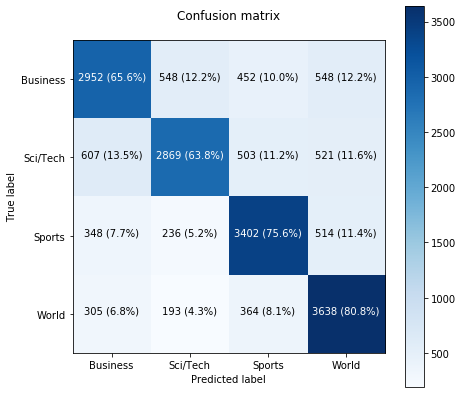

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      4500
           1       0.75      0.64      0.69      4500
           2       0.72      0.76      0.74      4500
           3       0.70      0.81      0.75      4500

    accuracy                           0.71     18000
   macro avg       0.72      0.71      0.71     18000
weighted avg       0.72      0.71      0.71     18000



In [48]:
# Confusion matrix
plt.rcParams["figure.figsize"] = (7,7)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, classes=classes)
print (classification_report(y_test, y_pred))

# Inference

In [0]:
import collections

### Components

In [0]:
def get_probability_distributions(probabilities, classes):
    """Produce probability distributions with labels."""
    probability_distributions = []
    for i, y_prob in enumerate(probabilities):
        probability_distribution = {}
        for j, prob in enumerate(y_prob):
            probability_distribution[classes[j]] = np.float64(prob)
        probability_distribution = collections.OrderedDict(
            sorted(probability_distribution.items(), key=lambda kv: kv[1], reverse=True))
        probability_distributions.append(probability_distribution)
    return probability_distributions

### Operations

In [51]:
# Inputs
texts = ["Roger Federer wins the Wimbledon tennis tournament once again.",
         "Scientist warn global warming is a serious scientific phenomenon."]
num_samples = len(texts)
X_infer = np.array(X_tokenizer.texts_to_sequences(texts))
print (f"X_infer[0] seq:\n{X_infer[0]}")
print (f"len(X_infer[0]): {len(X_infer[0])} characters")
X_infer = np.array([to_categorical(seq, num_classes=vocab_size) for seq in X_infer])
print (f"X_infer[0] one hot shape: {X_infer[0].shape}")
y_filler = np.array([0]*num_samples)

X_infer[0] seq:
[9, 7, 18, 3, 9, 2, 19, 3, 13, 3, 9, 3, 9, 2, 21, 8, 10, 4, 2, 6, 16, 3, 2, 21, 8, 17, 20, 11, 3, 13, 7, 10, 2, 6, 3, 10, 10, 8, 4, 2, 6, 7, 14, 9, 10, 5, 17, 3, 10, 6, 2, 7, 10, 12, 3, 2, 5, 18, 5, 8, 10, 26]
len(X_infer[0]): 62 characters
X_infer[0] one hot shape: (62, 58)


In [0]:
# Inference data generator
inference_generator = DataGenerator(X=X_infer,
                                    y=y_filler,
                                    batch_size=len(y_filler),
                                    vocab_size=vocab_size,
                                    max_filter_size=FILTER_SIZE,
                                    shuffle=False)

In [53]:
# Predict
probabilities = model.predict_generator(generator=inference_generator,
                                        verbose=1)

1/1 [==============================] - 0s 22ms/step


In [54]:
# Results
probability_distributions = get_probability_distributions(probabilities=probabilities,
                                                          classes=y_tokenizer.classes_)
results = []
for index in range(num_samples):
    results.append({
        'raw_input': texts[index],
        'preprocessed_input': untokenize_one_hot(seq=X_infer[index], tokenizer=X_tokenizer),
        'probabilities': probability_distributions[index]
                   })
print (json.dumps(results, indent=4))

[
    {
        "raw_input": "Roger Federer wins the Wimbledon tennis tournament once again.",
        "preprocessed_input": "r o g e r   f e d e r e r   w i n s   t h e   w i m b l e d o n   t e n n i s   t o u r n a m e n t   o n c e   a g a i n .",
        "probabilities": {
            "Sports": 0.37462228536605835,
            "Sci/Tech": 0.26097172498703003,
            "Business": 0.25116461515426636,
            "World": 0.11324141919612885
        }
    },
    {
        "raw_input": "Scientist warn global warming is a serious scientific phenomenon.",
        "preprocessed_input": "s c i e n t i s t   w a r n   g l o b a l   w a r m i n g   i s   a   s e r i o u s   s c i e n t i f i c   p h e n o m e n o m .",
        "probabilities": {
            "Sci/Tech": 0.7040546536445618,
            "World": 0.22490553557872772,
            "Business": 0.05717660114169121,
            "Sports": 0.01386315654963255
        }
    }
]


---
<div align="center">

Subscribe to our <a href="https://practicalai.me/#newsletter">newsletter</a> and follow us on social media to get the latest updates!

<a class="ai-header-badge" target="_blank" href="https://github.com/practicalAI/practicalAI">
              <img src="https://img.shields.io/github/stars/practicalAI/practicalAI.svg?style=social&label=Star"></a>&nbsp;
            <a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/practicalai-me">
              <img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
            <a class="ai-header-badge" target="_blank" href="https://twitter.com/practicalAIme">
              <img src="https://img.shields.io/twitter/follow/practicalAIme.svg?label=Follow&style=social">
            </a>
              </div>

</div>